In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, mutual_info_regression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
%matplotlib inline

In [319]:
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',10000)
df = pd.read_csv('/Users/mattlee/GA-Capstone-Project/FEdf.csv')
df.head()

,Name,Team,PPG,Games Played,MPG,FGM,FGA,FG%,FTM,FTA,FT%,3PM,3PA,3P%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF,Year,NBATeam,CollegeName,...,TotalDef,TotalPERWS,TotalPERWSBPM,TotalWSBPM,TotalWSBPMV,PERVORP,TotalWV,MPG3,FTMSR,3PMSR,ORBSR,DRBL,APGCR,SPGSR,TOVSR,Age at Draft SR,Height Inches C,TotalWSSR,TotalPCAWSSR,TotalPERWSSR,TotalWSBPMSR,TotalWSBPMVCR,PERVORPCR,Games Played 4,TotalOff
0,A.J. Price,UConn,12.466667,33.000000,29.30,4.166667,10.10,0.410667,2.633333,3.600000,0.719000,1.50,4.166667,0.348,0.800,2.433333,3.233333,4.566667,1.066667,0.066667,2.300000,1.300000,2009.0,IND,University of Connecticut,...,0.672569,0.478970,1.016996,0.621984,0.759839,0.532868,0.739942,25153.757000,1.622755,1.224745,0.894427,0.889262,1.659077,1.032796,1.516575,506.25,405224.0,1.074640,NaN,0.692077,0.788659,0.912516,0.810724,1.185921e+06,1.731432
1,Aaron Gray,PITT,8.750000,28.250000,18.40,3.425000,6.25,0.554250,1.900000,3.175000,0.590500,0.00,0.000000,0.000,2.275,3.975000,6.275000,1.175000,0.300000,1.025000,1.350000,1.975000,2007.0,CHI,University of Pittsburgh,...,1.537938,0.542123,1.152496,0.710822,0.861807,0.592658,0.758726,6229.504000,1.378405,0.000000,1.508310,1.380025,1.055227,0.547723,1.161895,497.29,614125.0,1.141701,NaN,0.736290,0.843103,0.951634,0.839978,6.369038e+05,2.684290
2,Al Horford,UF,9.866667,36.333333,25.50,3.766667,6.40,0.565333,2.433333,3.966667,0.612333,0.00,0.066667,0.000,2.300,5.500000,7.766667,1.633333,0.833333,1.700000,1.533333,2.433333,2007.0,ATL,University of Florida,...,1.949977,1.193208,1.970937,1.314461,1.728028,1.070043,0.989856,16581.375000,1.559915,0.000000,1.516575,1.704748,1.177674,0.912871,1.238278,432.64,551368.0,1.544184,0.641559,1.092341,1.146499,1.200006,1.022823,1.742693e+06,2.954779
3,Al-Farouq Aminu,WF,13.300000,31.000000,30.15,4.650000,9.80,0.481500,3.600000,5.200000,0.684500,0.40,1.550000,0.226,3.050,5.650000,8.700000,1.300000,1.150000,1.250000,2.650000,2.550000,2010.0,LAC,Wake Forest University,...,1.621651,0.612660,1.264872,0.844116,1.065122,0.641763,0.837860,27407.028375,1.897367,0.632456,1.746425,1.731656,1.091393,1.072381,1.627882,380.25,512000.0,1.218966,NaN,0.782726,0.918758,1.021253,0.862564,9.235210e+05,2.034810
4,Alec Burks,UCOL,18.450000,34.000000,30.80,6.100000,12.20,0.503000,5.650000,7.100000,0.798500,0.65,2.150000,0.322,2.100,3.500000,5.650000,2.300000,1.150000,0.350000,2.200000,2.350000,2011.0,UTA,University of Colorado,...,0.824115,0.629300,1.205679,0.727803,0.876599,0.626673,0.786119,29218.112000,2.376973,0.806226,1.449138,1.252763,1.320006,1.072381,1.483240,388.09,474552.0,1.163819,NaN,0.793285,0.853113,0.957048,0.855750,1.336336e+06,2.392888


In [48]:
def skb(x,y,features):
    kbest = SelectKBest(score_func= mutual_info_regression,k = features)
    kbest_columns = kbest.fit_transform(x,y)
    mask = kbest.get_support() #list of booleans
    new_features = [] # The list of your K best features
    for bool, feature in zip(mask, x.columns):
        if bool:
            new_features.append(feature)
    dfkbest = pd.DataFrame(kbest_columns, columns = new_features)
    scores = zip(x.columns,list(kbest.scores_))
    return dfkbest, scores
#made a function that can manually iterate number of desired KBest features

In [297]:
x = df[['PPG','Games Played 4','MPG3','FGM','FG%','FTMSR','FT%','3PMSR','3P%','ORBSR','DRBL','APGCR','SPGSR',
           'BPG','TOVSR','PF','Age at Draft SR','TopSchool','Weight at Draft','Height Inches C']]
y = df['TotalWSSR']

In [298]:
dfkbest, scores = skb(x,y,20)

In [299]:
scores

[('PPG', 0.041797204314645953),
 ('Games Played 4', 0.0),
 ('MPG3', 0.0),
 ('FGM', 0.10419583797111631),
 ('FG%', 0.018252562263861627),
 ('FTMSR', 0.12341078466213418),
 ('FT%', 0.0019262319986035337),
 ('3PMSR', 0.040967425349755171),
 ('3P%', 0.02895707164665362),
 ('ORBSR', 0.0),
 ('DRBL', 0.0),
 ('APGCR', 0.0),
 ('SPGSR', 0.020766054238236187),
 ('BPG', 0.0),
 ('TOVSR', 0.047180751127699594),
 ('PF', 0.0),
 ('Age at Draft SR', 0.055439764505240241),
 ('TopSchool', 0.045443247585907454),
 ('Weight at Draft', 0.0),
 ('Height Inches C', 0.0045185848693582997)]

In [300]:
dfkbest.columns

Index([u'PPG', u'Games Played 4', u'MPG3', u'FGM', u'FG%', u'FTMSR', u'FT%',
       u'3PMSR', u'3P%', u'ORBSR', u'DRBL', u'APGCR', u'SPGSR', u'BPG',
       u'TOVSR', u'PF', u'Age at Draft SR', u'TopSchool', u'Weight at Draft',
       u'Height Inches C'],
      dtype='object')

In [311]:
x_train, x_test, y_train, y_test = train_test_split(dfkbest, y,
                                                   test_size=0.30)

In [312]:
rg = LinearRegression()

In [313]:
rg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [314]:
rg.score(x_train, y_train)

0.4183789410822138

In [315]:
rg.score(x_test, y_test)

0.38208261189085008

In [320]:
df.columns

Index([u'Name', u'Team', u'PPG', u'Games Played', u'MPG', u'FGM', u'FGA',
       u'FG%', u'FTM', u'FTA', u'FT%', u'3PM', u'3PA', u'3P%', u'ORB', u'DRB',
       u'RPG', u'APG', u'SPG', u'BPG', u'TOV', u'PF', u'Year', u'NBATeam',
       u'CollegeName', u'Age at Draft', u'Weight at Draft', u'Height Inches',
       u'PER', u'WS', u'WS/48', u'BPM', u'VORP', u'TopSchool', u'Total',
       u'TotalWS', u'TotalWS48', u'TotalPCAWS', u'TotalPCAWS48', u'TotalDef',
       u'TotalPERWS', u'TotalPERWSBPM', u'TotalWSBPM', u'TotalWSBPMV',
       u'PERVORP', u'TotalWV', u'MPG3', u'FTMSR', u'3PMSR', u'ORBSR', u'DRBL',
       u'APGCR', u'SPGSR', u'TOVSR', u'Age at Draft SR', u'Height Inches C',
       u'TotalWSSR', u'TotalPCAWSSR', u'TotalPERWSSR', u'TotalWSBPMSR',
       u'TotalWSBPMVCR', u'PERVORPCR', u'Games Played 4', u'TotalOff'],
      dtype='object')

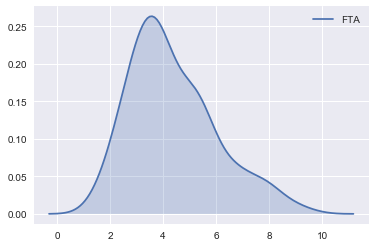

In [322]:
sns.kdeplot(df['FTA'], shade = True)

In [323]:
df['FTASR'] = df['FTA']**(0.5)

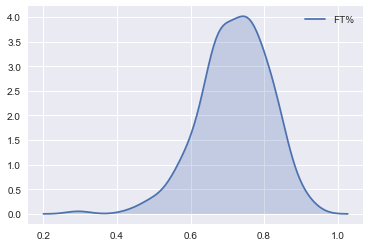

In [327]:
sns.kdeplot(df['FT%'], shade = True)

In [328]:
df['FT%C'] = df['FT%']**3

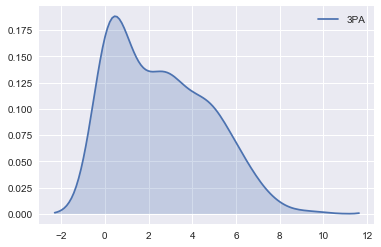

In [334]:
sns.kdeplot(df['3PA'], shade = True)

In [335]:
df['3PASR'] = np.sqrt(df['3PA'])

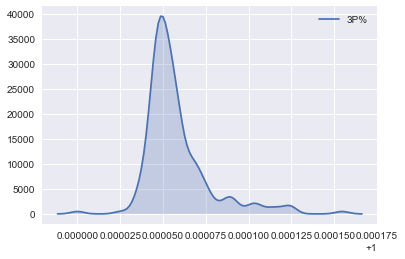

In [367]:
sns.kdeplot((df['3P%'])**(-0.00005), shade = True)

In [368]:
df['3P%R'] = df['3P%']**(-0.00005)

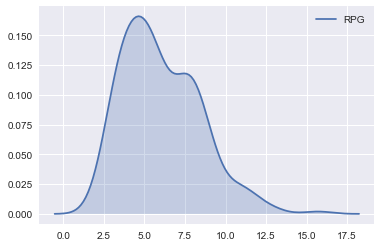

In [372]:
sns.kdeplot(df['RPG'], shade = True)

In [373]:
df['RPGSR'] = df['RPG']**(0.5)

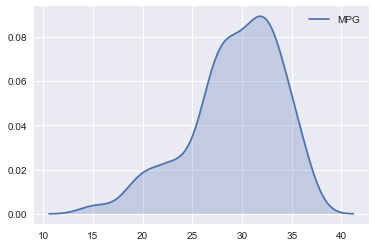

In [77]:
sns.kdeplot(x['MPG'], shade = True)

**Left skewed, lets cube it**

In [64]:
df['MPG3'] = df['MPG']**3

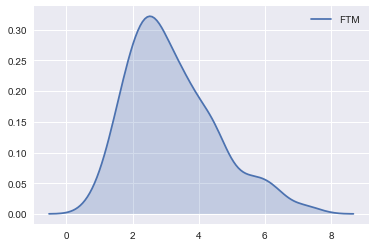

In [78]:
sns.kdeplot(x['FTM'], shade = True)

**Right skewed, lets take the square root**

In [69]:
df['FTMSR'] = df['FTM']**(0.5)

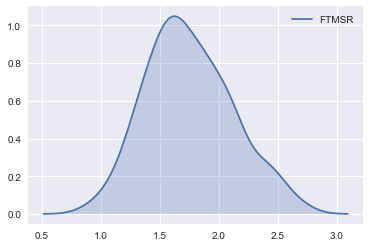

In [79]:
sns.kdeplot(df['FTMSR'], shade = True)

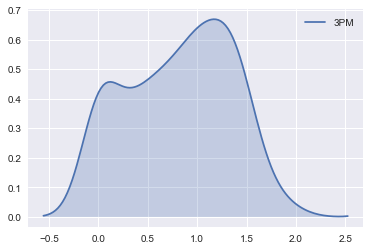

In [85]:
sns.kdeplot(df['3PM'], shade = True)

**Right skewed, we will take the square root**

In [86]:
df['3PMSR'] = df['3PM']**(0.5)

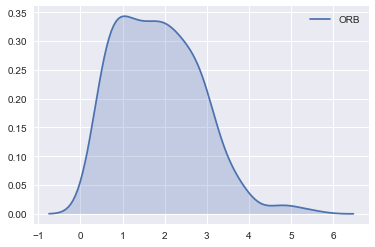

In [91]:
sns.kdeplot((df['ORB']), shade = True)

**Slightly right skewed, take square root**

In [92]:
df['ORBSR'] = df['ORB']**(0.5)

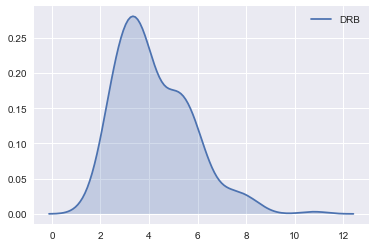

In [102]:
sns.kdeplot(df['DRB'], shade = True)

**Right skewed, take log**

In [103]:
df['DRBL'] = np.log(df['DRB'])

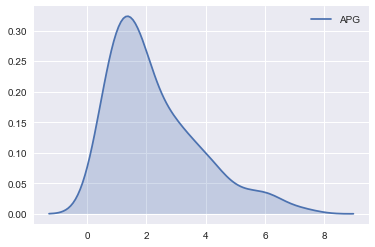

In [110]:
sns.kdeplot((df['APG']), shade = True)

**Right skewed, take cube root**

In [111]:
df['APGCR'] = np.cbrt(df['APG'])

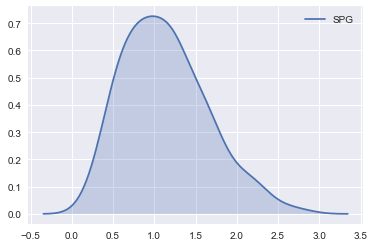

In [114]:
sns.kdeplot(df['SPG'], shade = True)

**Slightly right skewed, take the square root**

In [115]:
df['SPGSR'] = df['SPG']**(0.5)

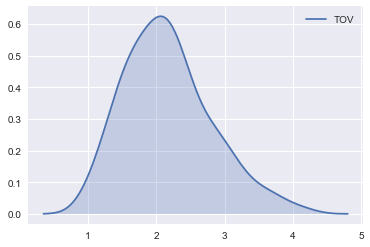

In [118]:
sns.kdeplot(df['TOV'], shade = True)

**Slightly right skewed, take the square root**

In [119]:
df['TOVSR'] = df['TOV']**(0.5)

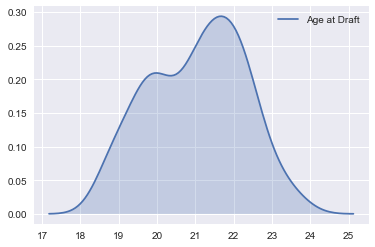

In [132]:
sns.kdeplot(df['Age at Draft'], shade = True)

**Square looks better**

In [133]:
df['Age at Draft SR'] = df['Age at Draft']**2

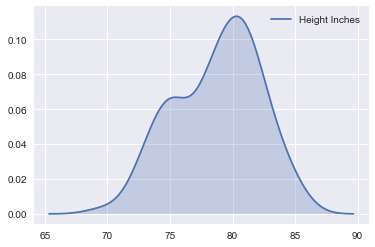

In [136]:
sns.kdeplot(df['Height Inches'], shade = True)

**Left skewed, take cube**

In [137]:
df['Height Inches C'] = df['Height Inches']**3

In [374]:
df.to_csv('FEdf1.csv', index = False)

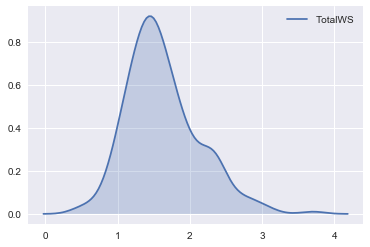

In [150]:
sns.kdeplot(df['TotalWS'], shade = True)

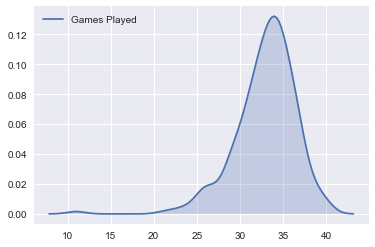

In [291]:
sns.kdeplot(df['Games Played'], shade = True)

In [292]:
df['Games Played 4'] = df['Games Played']**4

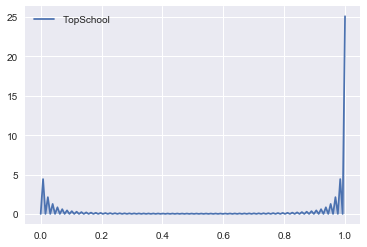

In [294]:
sns.kdeplot(df['TopSchool'], shade = True)

**Try to transform targets**

In [151]:
df['TotalWSSR'] = df['TotalWS']**(0.5)

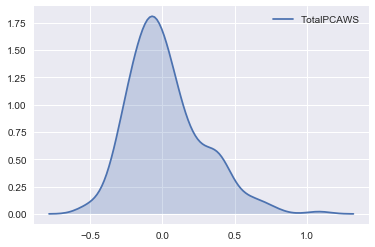

In [159]:
sns.kdeplot(df['TotalPCAWS'], shade = True)

In [160]:
df['TotalPCAWSSR'] = df['TotalPCAWS']**(0.5)

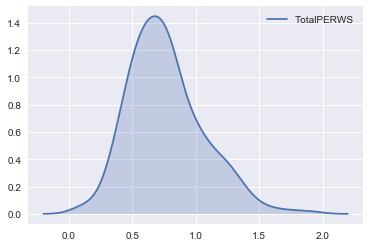

In [166]:
sns.kdeplot(df['TotalPERWS'], shade = True)

In [167]:
df['TotalPERWSSR'] = df['TotalPERWS']**(0.5)

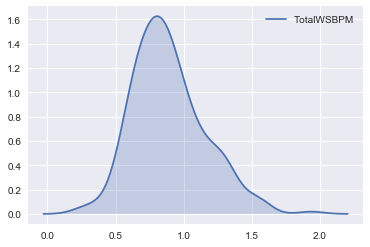

In [171]:
sns.kdeplot(df['TotalWSBPM'], shade = True)

In [172]:
df['TotalWSBPMSR'] = df['TotalWSBPM']**(0.5)

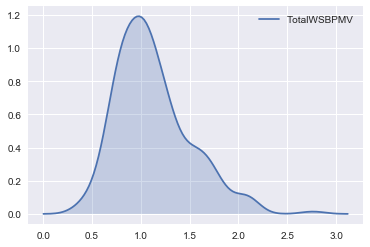

In [178]:
sns.kdeplot(df['TotalWSBPMV'], shade = True)

In [179]:
df['TotalWSBPMVCR'] = np.cbrt(df['TotalWSBPMV'])

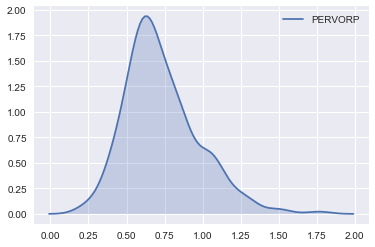

In [187]:
sns.kdeplot(df['PERVORP'], shade = True)

In [188]:
df['PERVORPCR'] = np.cbrt(df['PERVORP'])

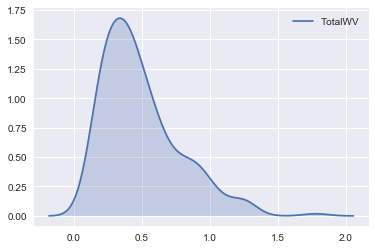

In [200]:
sns.kdeplot((df['TotalWV']), shade = True)

In [201]:
df['TotalWV'] = df['TotalWV']**(0.2)